# COMP30027 Machine Learning Project 2

## Description of text features

This notebook describes the pre-computed text features provided for Project 2. **You do not need to recompute the features yourself for this assignment** -- this information is just for your reference. However, feel free to experiment with different text features if you are interested. If you do want to try generating your own text features, some things to keep in mind:
- There are many different decisions you can make throughout the feature design process, from the text preprocessing to the size of the output vectors. There's no guarantee that the defaults we chose will produce the best possible text features for this classification task, so feel free to experiment with different settings.
- These features must be trained using a training corpus. Generally, the training corpus should not include validation samples, but for the purposes of this assignment we have used the entire non-test set (training+validation) as the training corpus, to allow you to experiment with different validation sets. If you recompute the text features as part of your own model, you should exclude validation samples and compute them on training samples only. For example, if you do N-fold cross-validation, this means generating N sets of features for N different training-validation splits.

In [489]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import pickle
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= 'darkgrid')
sns.set_palette('deep')

In [493]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [249]:
# read text
# for DEMONSTRATION PURPOSES, the entire training set will be used to train the models and also as a test set
x_train_original = pd.read_csv(r"book_rating_train.csv", index_col = False, delimiter = ',', header=0)
# use recipe name as an example
y = x_train_original['rating_label']
train_corpus_name = x_train_original['Name']
test_name = x_train_original['Name']

In [250]:
x_train_original.head()

,Name,Authors,PublishYear,PublishMonth,PublishDay,Publisher,Language,pagesNumber,Description,rating_label
0,Best of Dr Jean: Reading & Writing,Jean R. Feldman,2005,6,1,Teaching Resources,NaN,48,Teachers will turn to this treasury of ideas a...,4.0
1,Here All Dwell Free,Gertrud Mueller Nelson,1991,10,1,DoubleDay,NaN,364,Every human being lives a fairy tale -- an unc...,4.0
2,Boomer's Big Surprise,Constance W. McGeorge,2005,3,31,Chronicle Books,NaN,32,<i>Boomer's Big Surprise</i> will have special...,4.0
3,"I'll Go and Do More: Annie Dodge Wauneka, Nava...",Carolyn Niethammer,2004,9,1,Bison Books,NaN,293,<i>I'll Go and Do More</i> is the story of Ann...,4.0
4,Us,Richard Mason,2005,7,7,Penguin Books Ltd,eng,352,"Since their days at Oxford, they've gone their...",3.0


In [395]:
x_train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23063 entries, 0 to 23062
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          23063 non-null  object 
 1   Authors       23063 non-null  object 
 2   PublishYear   23063 non-null  int64  
 3   PublishMonth  23063 non-null  int64  
 4   PublishDay    23063 non-null  int64  
 5   Publisher     22915 non-null  object 
 6   Language      5861 non-null   object 
 7   pagesNumber   23063 non-null  int64  
 8   Description   23063 non-null  object 
 9   rating_label  23063 non-null  float64
dtypes: float64(1), int64(4), object(5)
memory usage: 1.8+ MB


## Count vectorizer

A count vectorizer converts documents to vectors which represent word counts. Each column in the output represents a different word and the values indicate the number of times that word appeared in the document. The overall size of a count vector matrix can be quite large (the number of columns is the total number of different words used across all documents in a corpus), but most entries in the matrix are zero (each document contains only a few of all the possible words). Therefore, it is most efficient to represent the count vectors as a sparse matrix.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# preprocess text and compute counts
vocab_name = CountVectorizer(stop_words='english').fit(train_corpus_name)

# generate counts for a new set of documents
x_train_name = vocab_name.transform(train_corpus_name)
x_test_name = vocab_name.transform(test_name)

# check the number of words in vocabulary
print(len(vocab_name.vocabulary_))
# check the shape of sparse matrix
print(x_train_name.shape)

20766
(23063, 20766)


## doc2vec

doc2vec methods are an extension of word2vec. word2vec maps words to a high-dimensional vector space in such a way that words which appear in similar contexts will be close together in the space. doc2vec does a similar embedding for multi-word passages. The doc2vec (or Paragraph Vector) method was introduced by:

**Le & Mikolov (2014)** Distributed Representations of Sentences and Documents<br>
https://arxiv.org/pdf/1405.4053v2.pdf

The implementation of doc2vec used for this project is from gensim and documented here:<br>
https://radimrehurek.com/gensim/models/doc2vec.html

The size of the output vector is a free parameter. Most implemementations use around 100-300 dimensions, but the best size depends on the problem you're trying to solve with the embeddings and the number of training samples, so you may wish to try different vector sizes. We provided doc2vec features for Name (vec_size = 100), Authors (vec_size = 20) and Description (vec_size = 100). The vectors themselves represent directions in a high-dimensional concept space; the columns do not represent specific words or phrases. Values in the vector are continuous real numbers and can be negative.

In [6]:
import gensim

# size of the output vector
vec_size = 100

# function to preprocess and tokenize text
def tokenize_corpus(txt, tokens_only=False):
    for i, line in enumerate(txt):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

# tokenize a training corpus
corpus_name = list(tokenize_corpus(train_corpus_name))

# train doc2vec on the training corpus
model = gensim.models.doc2vec.Doc2Vec(vector_size=vec_size, min_count=2, epochs=40)
model.build_vocab(corpus_name)
model.train(corpus_name, total_examples=model.corpus_count, epochs=model.epochs)

# tokenize new documents
doc = list(tokenize_corpus(test_name, tokens_only=True))

# generate embeddings for the new documents
x_test_name = np.zeros((len(doc),vec_size))
for i in range(len(doc)):
    x_test_name[i,:] = model.infer_vector(doc[i])
    
# check the shape of doc_emb
print(x_test_name.shape)

(23063, 100)


/Users/clardelia/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2]), [Text(0, 0, '3.0'), Text(1, 0, '4.0'), Text(2, 0, '5.0')])

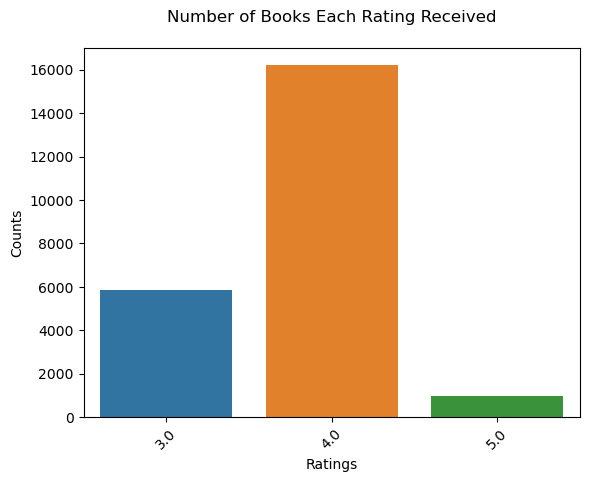

In [240]:
sns.barplot(y.value_counts().index, y.value_counts())
plt.title('Number of Books Each Rating Received\n')
plt.xlabel('Ratings')
plt.ylabel('Counts')
plt.xticks(rotation=45)

<AxesSubplot:xlabel='PublishYear'>

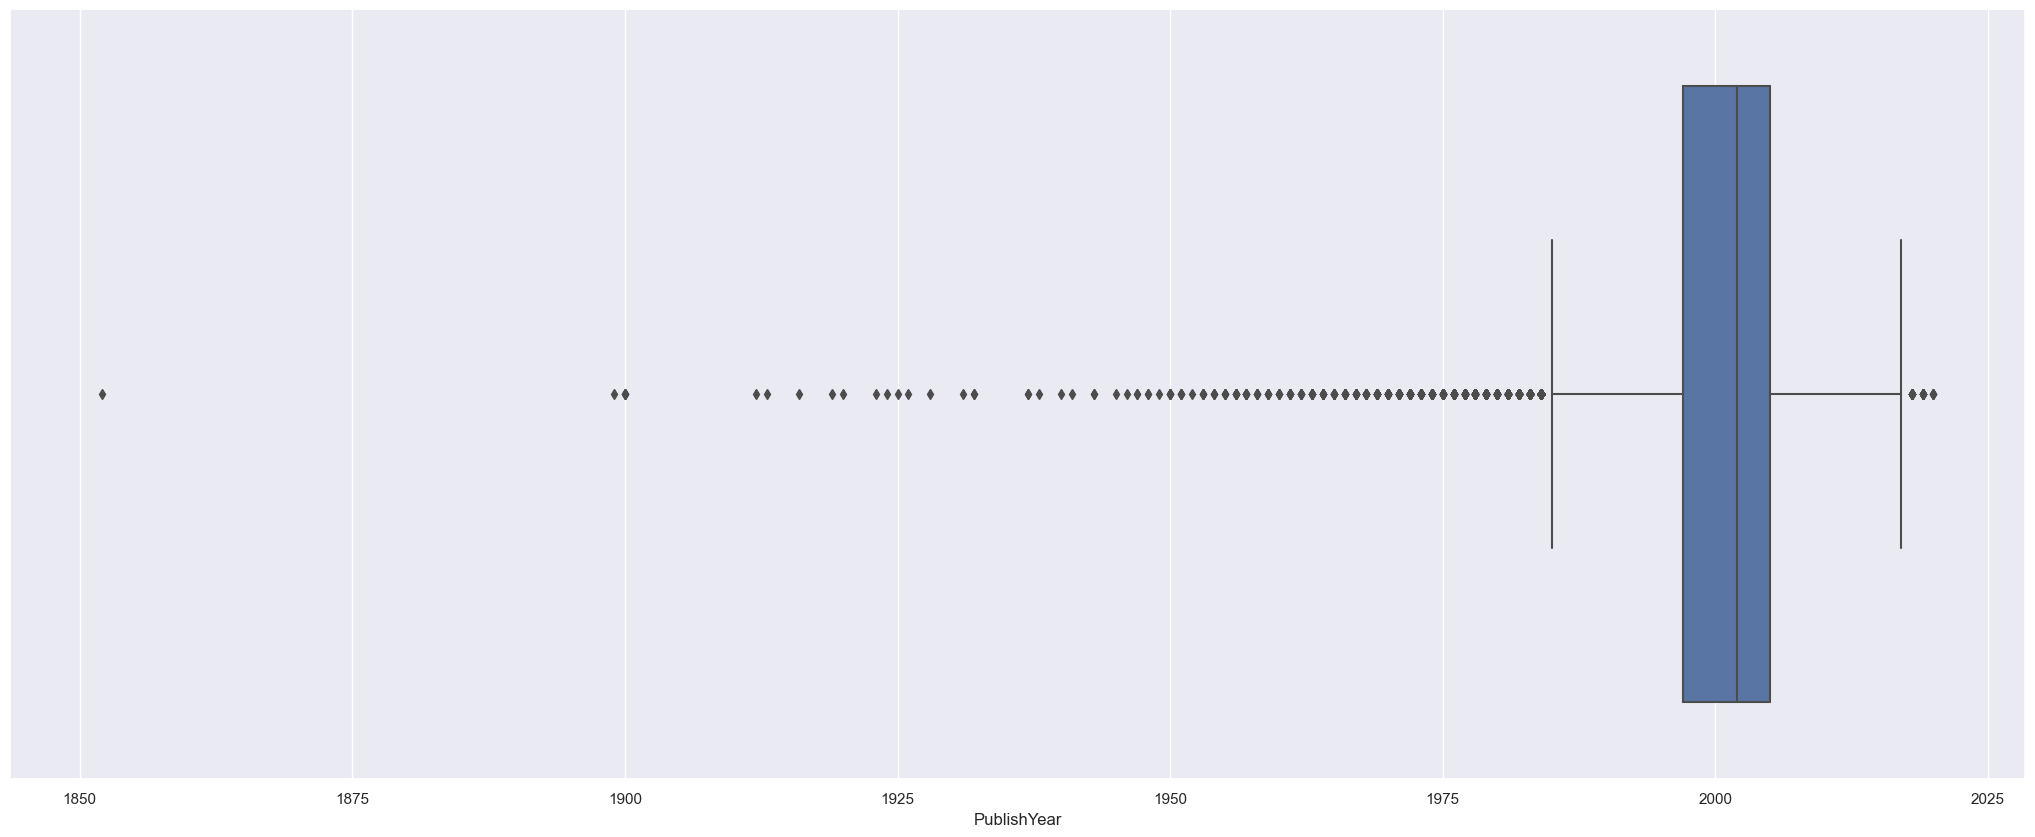

In [490]:
fig = plt.gcf()
fig.set_size_inches(26, 10)
fig.set
sns.boxplot(x=x_train_original['PublishYear'])

<AxesSubplot:xlabel='pagesNumber'>

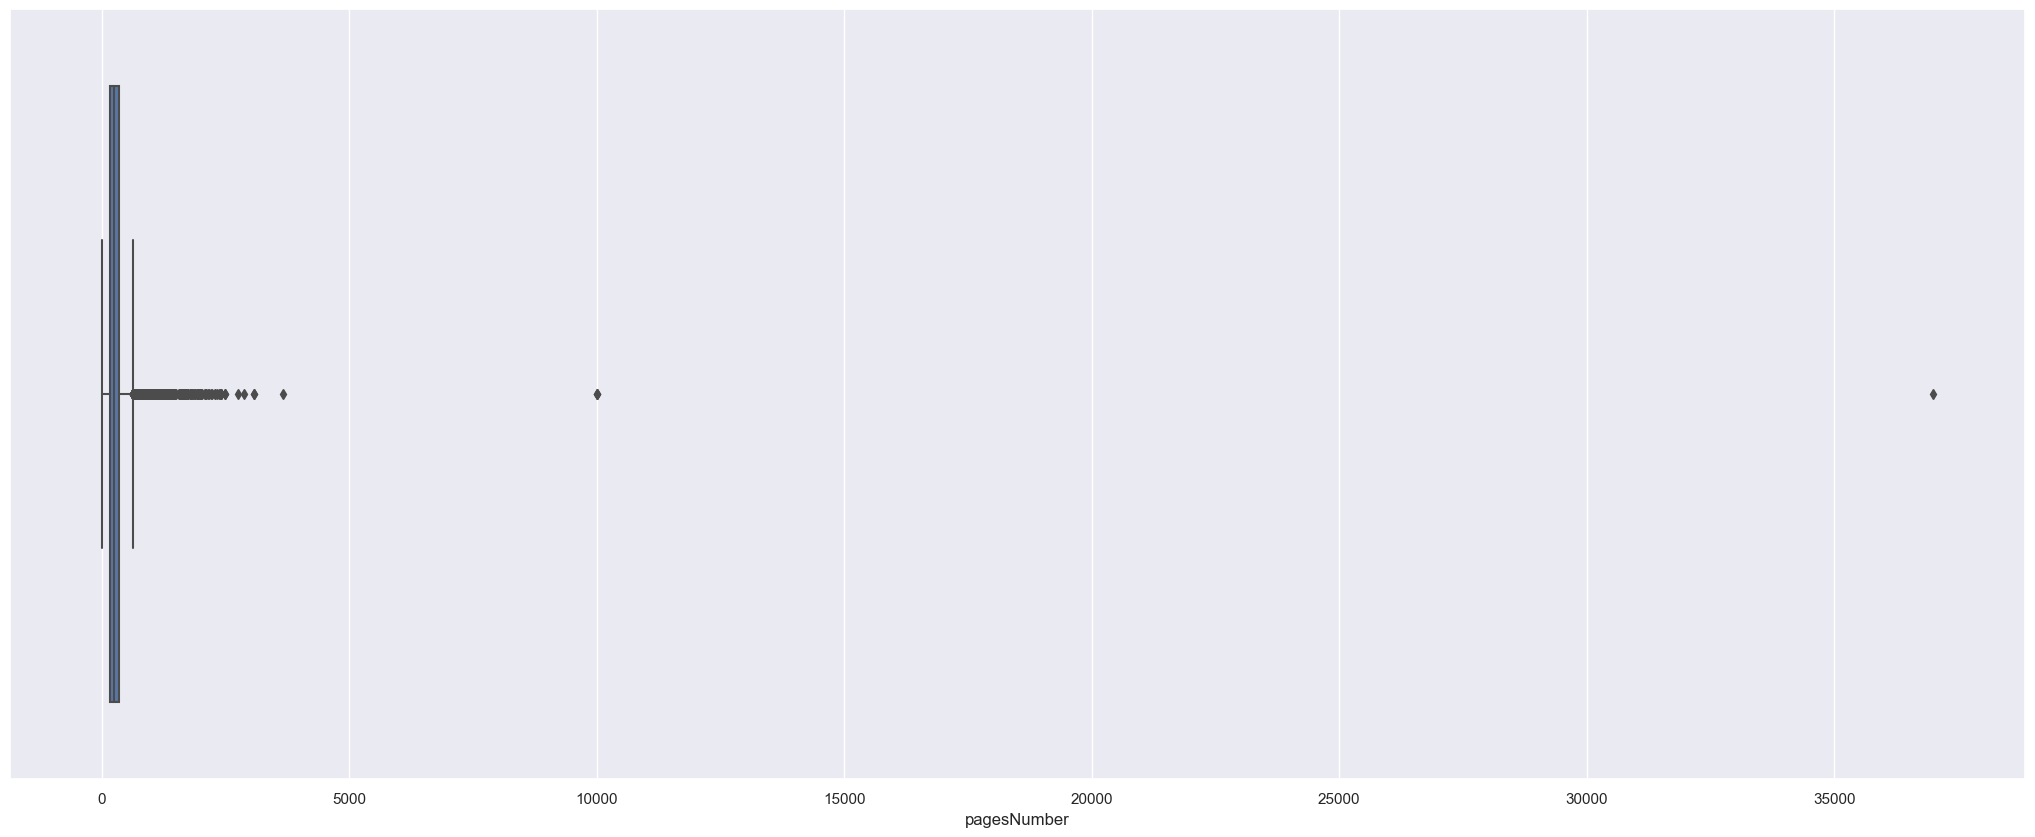

In [491]:
fig = plt.gcf()
fig.set_size_inches(26, 10)
sns.boxplot(x=x_train_original['pagesNumber'])

In [498]:
# Extract name, authors and description after processing each of it using countvectorizer
vector_name = sp.load_npz('book_text_features_countvec/train_name_vec.npz')
vector_auth = sp.load_npz('book_text_features_countvec/train_authors_vec.npz')
vector_desc = sp.load_npz('book_text_features_countvec/train_desc_vec.npz')

In [499]:
# Create count vectorizer for publisher
from sklearn.feature_extraction.text import CountVectorizer

x_train_original['Publisher'].fillna('Unknown', inplace=True)

# preprocess text and compute counts
vocab_name = CountVectorizer(stop_words='english').fit(x_train_original['Publisher'])

# generate counts for a new set of documents
publisher = vocab_name.transform(x_train_original['Publisher'])

# check the number of words in vocabulary
print(len(vocab_name.vocabulary_))
# check the shape of sparse matrix
print(publisher.shape)

3616
(23063, 3616)


In [500]:
# Combine all the sparse matrices in one dataframe
temp = hstack((vector_name, vector_auth, vector_desc))
vector = hstack((temp, x_train_original['PublishYear'].values.reshape(-1,1), x_train_original['PublishMonth'].values.reshape(-1,1), x_train_original['PublishDay'].values.reshape(-1,1), x_train_original['pagesNumber'].values.reshape(-1,1), publisher))
vector.shape

(23063, 130504)

In [501]:
# Split the training data into training and test for training purposes
X_train, X_test, y_train, y_test = train_test_split(vector, y, test_size=0.2, stratify=y, random_state=10)

In [502]:
# Feature Scaling for LSVM
scaler = MaxAbsScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [503]:
# Linear SVC accuracy between different C values
models = [svm.LinearSVC(C=0.0001),
          svm.LinearSVC(C=0.001),
          svm.LinearSVC(C=0.01),
          svm.LinearSVC(C=0.1),
          svm.LinearSVC(C=1.0),
          svm.LinearSVC(C=10.0)]

names = ['LinearSVC (C=0.0001)',
          'LinearSVC (C=0.001)',
          'LinearSVC (C=0.01)',
          'LinearSVC (C=0.1)',
          'LinearSVC (C=1.0)',
          'LinearSVC (C=10.0)']

accuracies = []
for name, model in zip(names, models):
    print(name, ':')
    model.fit(X_train_norm, y_train)
    acc = model.score(X_test_norm, y_test)
    accuracies.append(acc)
    print(f'Accuracy: {acc}\n')

LinearSVC (C=0.0001) :
Accuracy: 0.7027964448298287

LinearSVC (C=0.001) :
Accuracy: 0.7027964448298287

LinearSVC (C=0.01) :
Accuracy: 0.7186212876652938

LinearSVC (C=0.1) :
Accuracy: 0.7019293301539129

LinearSVC (C=1.0) :
Accuracy: 0.6761326685454151

LinearSVC (C=10.0) :
Accuracy: 0.6707132018209409



/Users/clardelia/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


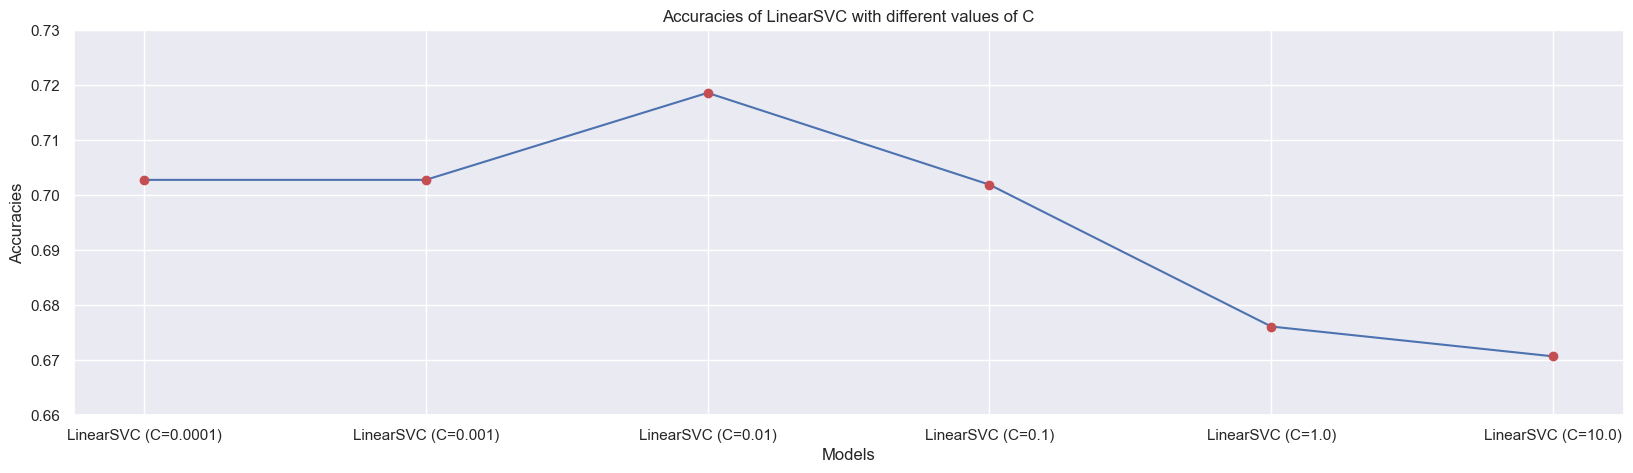

In [504]:
# Figure of Linear SVC accuracy between different C values
fig = plt.figure(figsize = (20, 5))
plt.plot(names, accuracies)
plt.plot(names, accuracies, 'ro')
plt.title("Accuracies of LinearSVC with different values of C")
plt.xlabel("Models")
plt.ylabel("Accuracies")
plt.ylim([0.66, 0.73])
plt.show()

In [505]:
# Linear SVC accuracy between different class weight values
C = 0.01

models = [svm.LinearSVC(C=C, class_weight={3.0: 0.4, 4.0: 0.1, 5.0: 0.5}),
          svm.LinearSVC(C=C, class_weight={3.0: 0.3, 4.0: 0.2, 5.0: 0.5}),
          svm.LinearSVC(C=C, class_weight={3.0: 0.4, 4.0: 0.2, 5.0: 0.4})]

names = ['LinearSVC (w=0.4,0.1,0.5)',
         'LinearSVC (w=0.3,0.2,0.5)',
         'LinearSVC (w=0.4,0.2,0.4)']

accuracies = []
for name, model in zip(names, models):
    print(name, ':')
    model.fit(X_train_norm, y_train)
    acc = model.score(X_test_norm, y_test)
    accuracies.append(acc)
    print(f'Accuracy: {acc}\n')

LinearSVC (w=0.4,0.1,0.5) :
Accuracy: 0.7099501409061348

LinearSVC (w=0.3,0.2,0.5) :
Accuracy: 0.7181877303273357

LinearSVC (w=0.4,0.2,0.4) :
Accuracy: 0.7194884023412096



In [506]:
# Linear SVC accuracy between different type of multi class
C = 0.01
class_weight = {3.0: 0.4, 4.0: 0.2, 5.0: 0.4}

models = [svm.LinearSVC(C=C, class_weight=class_weight),
          svm.LinearSVC(C=C, class_weight=class_weight, multi_class='crammer_singer')]

names = ['LinearSVC using ovr', 
         'LinearSVC using crammer singer']

accuracies = []
for name, model in zip(names, models):
    print(name, ':')
    model.fit(X_train_norm, y_train)
    acc = model.score(X_test_norm, y_test)
    accuracies.append(acc)
    y_pred = model.predict(X_test_norm)
    precision = precision_score(y_test, y_pred, average='weighted')  
    recall = recall_score(y_test, y_pred, average='weighted') 
    f1 = f1_score(y_test, y_pred, average='weighted')  
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion matrix:\n{cm}')
    print(f'Accuracy: {acc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'f1: {f1}')

LinearSVC using ovr :
Confusion matrix:
[[ 199  974    0]
 [ 131 3110    1]
 [   5  183   10]]
Accuracy: 0.7194884023412096
Precision: 0.7023035927945842
Recall: 0.7194884023412096
f1: 0.6533727171926949
LinearSVC using crammer singer :
Confusion matrix:
[[  19 1154    0]
 [   3 3239    0]
 [   0  198    0]]
Accuracy: 0.7062649035334922
Precision: 0.715437114605475
Recall: 0.7062649035334922
f1: 0.58930837468348


/Users/clardelia/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/clardelia/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [508]:
# Accuracies of different values of k using Logistic Regression
models = [LogisticRegression(max_iter=10000)]
names = ['Logistic Regression']
k_val = [250, 500, 750, 1000, 2000, 5000, 10000]

X_label = []

accuracies = []
for name, model in zip(names, models):
    print(name)
    for k in k_val:
        x = SelectKBest(chi2, k=k)
        x.fit(X_train, y_train)
        X_train_x = x.fit_transform(X_train, y_train)
        X_test_x = x.transform(X_test)

        model.fit(X_train_x, y_train)
        acc = model.score(X_test_x, y_test)
        accuracies.append(acc)
        X_label.append(f'SelectKBest (k={k})')
        print(f'SelectKBest (k={k})\t Accuracy: {acc}')

Logistic Regression
SelectKBest (k=250)	 Accuracy: 0.7114675915889876
SelectKBest (k=500)	 Accuracy: 0.7119011489269456
SelectKBest (k=750)	 Accuracy: 0.7132018209408194
SelectKBest (k=1000)	 Accuracy: 0.7147192716236722
SelectKBest (k=2000)	 Accuracy: 0.7153696076306092
SelectKBest (k=5000)	 Accuracy: 0.7082159115543031
SelectKBest (k=10000)	 Accuracy: 0.7034467808367657


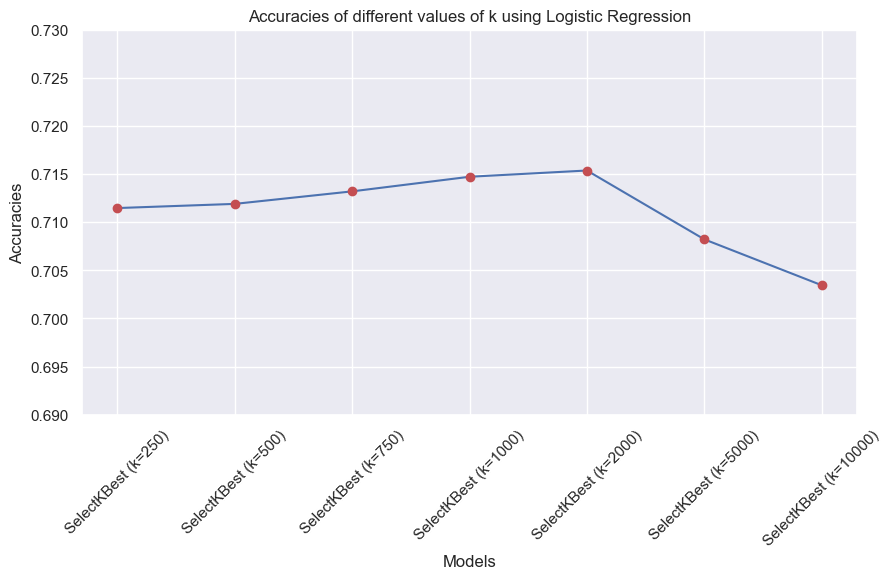

In [509]:
# Figure of accuracies of different values of k using Logistic Regression
fig = plt.figure(figsize=(10, 5))

plt.plot(X_label, accuracies)
plt.plot(X_label, accuracies, 'ro')
plt.title("Accuracies of different values of k using Logistic Regression")
plt.xlabel("Models")
plt.ylabel("Accuracies")
plt.ylim([0.69, 0.73])
plt.xticks(rotation=45)

plt.show()

In [510]:
k = 1000
x = SelectKBest(chi2, k=k)
X_train_x = x.fit_transform(X_train, y_train)
X_test_x = x.transform(X_test)

In [511]:
# Logistic Regression accuracy value for different types of solver

models = [LogisticRegression(solver='lbfgs', max_iter=10000), 
          LogisticRegression(solver='sag', max_iter=10000), 
          LogisticRegression(solver='saga', max_iter=10000)] 
names = ['Logistic Regression with lbfgs solver',
         'Logistic Regression with sag solver', 
         'Logistic Regression with saga solver']

accuracies = []
for name, model in zip(names, models):
    print(name, '(k =',k,'features)')
    model.fit(X_train_x, y_train)
    acc = model.score(X_test_x, y_test)
    accuracies.append(acc)
    print(f'Accuracy: {acc}\n')

Logistic Regression with lbfgs solver (k = 1000 features)
Accuracy: 0.7147192716236722

Logistic Regression with sag solver (k = 1000 features)
Accuracy: 0.7027964448298287

Logistic Regression with saga solver (k = 1000 features)
Accuracy: 0.7027964448298287



In [514]:
# Logistic Regression accuracy value for C values
solver = 'lbfgs'

models = [LogisticRegression(solver=solver, C=1, max_iter=10000), 
          LogisticRegression(solver=solver, C=0.1, max_iter=10000),
          LogisticRegression(solver=solver, C=0.01, max_iter=10000),
          LogisticRegression(solver=solver, C=0.001, max_iter=10000)] 
names = ['Logistic Regression with C=1',
         'Logistic Regression with C=0.1', 
         'Logistic Regression with C=0.01',
         'Logistic Regression with C=0.001']

accuracies = []
for name, model in zip(names, models):
    print(name, '(k =',k,'features):')
    model.fit(X_train_x, y_train)
    acc = model.score(X_test_x, y_test)
    accuracies.append(acc)
    print(f'Accuracy: {acc}\n')

Logistic Regression with C=1 (k = 1000 features):
Accuracy: 0.7147192716236722

Logistic Regression with C=0.1 (k = 1000 features):
Accuracy: 0.7142857142857143

Logistic Regression with C=0.01 (k = 1000 features):
Accuracy: 0.708649468892261

Logistic Regression with C=0.001 (k = 1000 features):
Accuracy: 0.7045306741816605



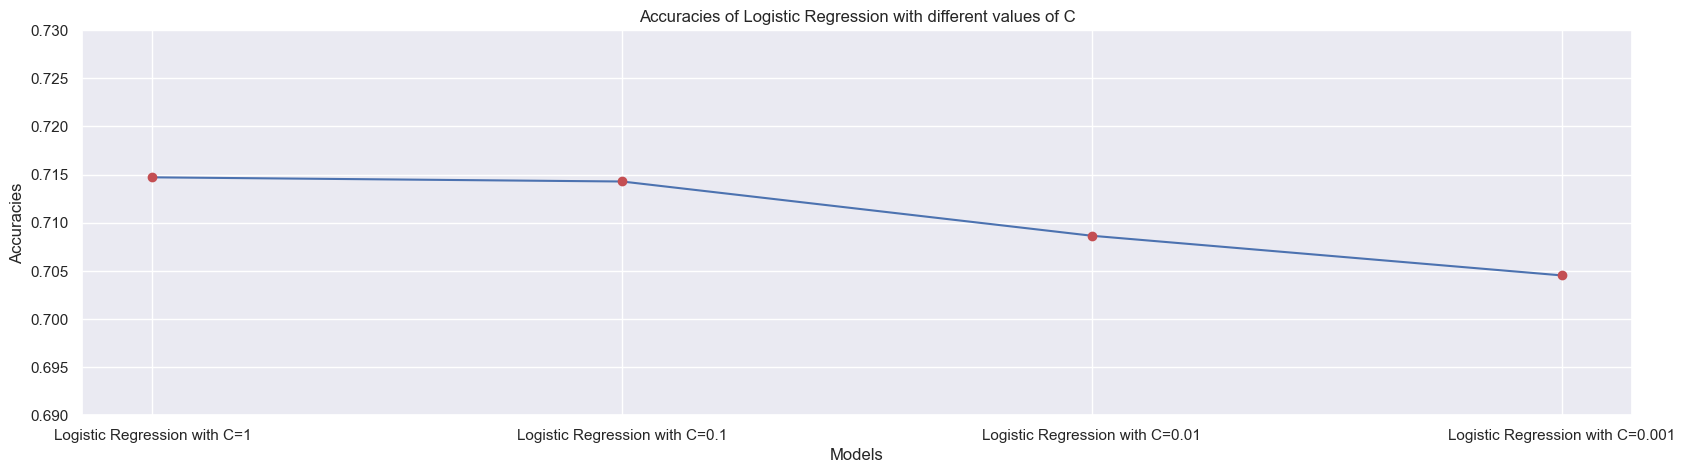

In [515]:
# Figure for accuracy with different C values of Logistic Regression
fig = plt.figure(figsize = (20, 5))
plt.plot(names, accuracies)
plt.plot(names, accuracies, 'ro')
plt.title("Accuracies of Logistic Regression with different values of C")
plt.xlabel("Models")
plt.ylabel("Accuracies")
plt.ylim([0.69, 0.73])
plt.show()

In [516]:
# Logistic Regression accuracies for different types of multi class
solver = 'lbfgs'
C = 0.1

models = [LogisticRegression(solver=solver, C=C, multi_class='multinomial', max_iter=10000), 
          LogisticRegression(solver=solver, C=C, multi_class='ovr', max_iter=10000)] 
names = ['Logistic Regression with multinomial',
         'Logistic Regression with ovr']

accuracies = []
for name, model in zip(names, models):
    print(name, '(k =',k,'features):')
    model.fit(X_train_x, y_train)
    acc = model.score(X_test_x, y_test)
    accuracies.append(acc)
    y_pred = model.predict(X_test_x)
    precision = precision_score(y_test, y_pred, average='weighted')  
    recall = recall_score(y_test, y_pred, average='weighted') 
    f1 = f1_score(y_test, y_pred, average='weighted')  
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion matrix:\n{cm}')
    print(f'Accuracy: {acc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'f1: {f1}')

Logistic Regression with multinomial (k = 1000 features):
Confusion matrix:
[[ 106 1066    1]
 [  59 3173   10]
 [   1  181   16]]
Accuracy: 0.7142857142857143
Precision: 0.6923266157788107
Recall: 0.7142857142857143
f1: 0.6284505546779162
Logistic Regression with ovr (k = 1000 features):
Confusion matrix:
[[  89 1084    0]
 [  53 3185    4]
 [   0  187   11]]
Accuracy: 0.7121179275959245
Precision: 0.6931852330723702
Recall: 0.7121179275959245
f1: 0.6204084982346447


In [517]:
# Extract the matrices of name, author and description for the test dataset
x_test_original = pd.read_csv(r"book_rating_test.csv", index_col = False, delimiter = ',', header=0)
vector_name_tst = sp.load_npz('book_text_features_countvec/test_name_vec.npz')
vector_auth_tst = sp.load_npz('book_text_features_countvec/test_authors_vec.npz')
vector_desc_tst = sp.load_npz('book_text_features_countvec/test_desc_vec.npz')

In [270]:
x_test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5766 entries, 0 to 5765
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          5766 non-null   object
 1   Authors       5766 non-null   object
 2   PublishYear   5766 non-null   int64 
 3   PublishMonth  5766 non-null   int64 
 4   PublishDay    5766 non-null   int64 
 5   Publisher     5734 non-null   object
 6   Language      1526 non-null   object
 7   pagesNumber   5766 non-null   int64 
 8   Description   5766 non-null   object
dtypes: int64(4), object(5)
memory usage: 405.5+ KB


In [518]:
x_test_original['Publisher'].fillna('Unknown', inplace=True)

# preprocess text and compute counts
vocab_name_tst = CountVectorizer(stop_words='english').fit(x_test_original['Publisher'])

# generate counts for a new set of documents
publisher_tst = vocab_name.transform(x_test_original['Publisher'])

# check the number of words in vocabulary
print(len(vocab_name_tst.vocabulary_))
# check the shape of sparse matrix
print(publisher_tst.shape)

1996
(5766, 3616)


In [519]:
temp_tst = hstack((vector_name_tst, vector_auth_tst, vector_desc_tst))
X_test = hstack((temp_tst, x_test_original['PublishYear'].values.reshape(-1,1), x_test_original['PublishMonth'].values.reshape(-1,1), x_test_original['PublishDay'].values.reshape(-1,1), x_test_original['pagesNumber'].values.reshape(-1,1), publisher_tst))
X_test.shape

(5766, 130504)

In [460]:
predictions = {}

In [520]:
# Normalisation for LinearSVC
scaler = MaxAbsScaler()

X_train_norm = scaler.fit_transform(vector)
X_test_norm = scaler.transform(X_test)

In [521]:
# Results of using Linear SVM classifier on the test dataset
C = 0.01
class_weight = {3.0: 0.4, 4.0: 0.2, 5.0: 0.4}

model = svm.LinearSVC(C=C, class_weight=class_weight)
name = 'LinearSVC'

model.fit(X_train_norm, y)
predictions[name] = model.predict(X_test_norm)

In [522]:
# Convert the predicted labels into the appropriate format for submission in kaggle and lms
data = {'id': list(range(1,5767)), 'rating_label': predictions['LinearSVC']}
df = pd.DataFrame(data, columns=['id','rating_label'])
df.to_csv('prediction_lsvc.csv', index=False)

In [523]:
# Feature Selection for Logistic Regression
k = 1000
x = SelectKBest(chi2, k=k)
X_train_x = x.fit_transform(vector,y)
X_test_x = x.transform(X_test)

In [524]:
# Results of using Logistic Regression classifier on the test dataset
solver = 'lbfgs'
C = 0.1
multi_class = 'multinomial'

model = LogisticRegression(solver=solver, C=C, multi_class=multi_class, max_iter=10000)
name = 'Logistic Regression'

model.fit(X_train_x, y)
predictions[name] = model.predict(X_test_x)

In [525]:
# Convert the predicted labels into the appropriate format for submission in kaggle and lms
data = {'id': list(range(1,5767)), 'rating_label': predictions['Logistic Regression']}
df = pd.DataFrame(data, columns=['id','rating_label'])
df.to_csv('prediction_lr.csv', index=False)